This command installs the necessary Kaggle library so that your notebook can interact with the Kaggle website.


In [1]:
%pip install kaggle

Upload Your Kaggle API Key

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"timniel","key":"bbf5c5bdc49ec12464bcdaeee5a35de0"}'}

Configure the Kaggle API Key

In [3]:
import os

# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
!mv kaggle.json ~/.kaggle/

# Set the permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

Download the Competition Dataset

In [4]:
!kaggle competitions download -c facial-keypoints-detection

facial-keypoints-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip the Main Dataset File

In [5]:
!unzip facial-keypoints-detection.zip

Archive:  facial-keypoints-detection.zip
replace IdLookupTable.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: IdLookupTable.csv       
replace SampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SampleSubmission.csv    
replace test.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.zip                
replace training.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.zip            


 Unzip the Training Data

In [6]:
!unzip training.zip

Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.csv            


Unzip the Test Data

In [7]:
!unzip test.zip

Archive:  test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


Import All Necessary Libraries

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Load the CSV Files into Pandas DataFrames

In [9]:
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')

Handle Missing Data

In [10]:
train_df.dropna(inplace=True)

 Convert Data for the Model

In [11]:
X = np.array([np.fromstring(image, dtype=int, sep=' ') for image in train_df['Image']]).reshape(-1, 96, 96, 1) / 255.0
y = train_df.drop('Image', axis=1).values

Split Data into Training and Validation Sets

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Define the Neural Network Architecture

In [13]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(30)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the Model

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

Train the Model

In [15]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 525ms/step - loss: 946.9924 - mae: 23.4277 - val_loss: 2691.5784 - val_mae: 48.1061
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 122.7349 - mae: 8.6869 - val_loss: 2785.9700 - val_mae: 48.4506
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 78.2882 - mae: 6.9900 - val_loss: 2822.6978 - val_mae: 48.3832
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 56.2263 - mae: 5.9242 - val_loss: 2811.2290 - val_mae: 48.0825
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 49.0684 - mae: 5.5408 - val_loss: 2787.3499 - val_mae: 47.7432
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 41.8139 - mae: 5.1384 - val_loss: 2682.6492 - val_mae: 46.9313
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 41.2724 - mae: 5.0759 - val_loss: 2582.3201 - val_mae: 46.0920
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 37.4043 - mae: 4.8275 - val_loss: 2311.4392 - val_mae: 43.8756
Epoch 9/100

Visualizing the Learning Process (The Graphs)

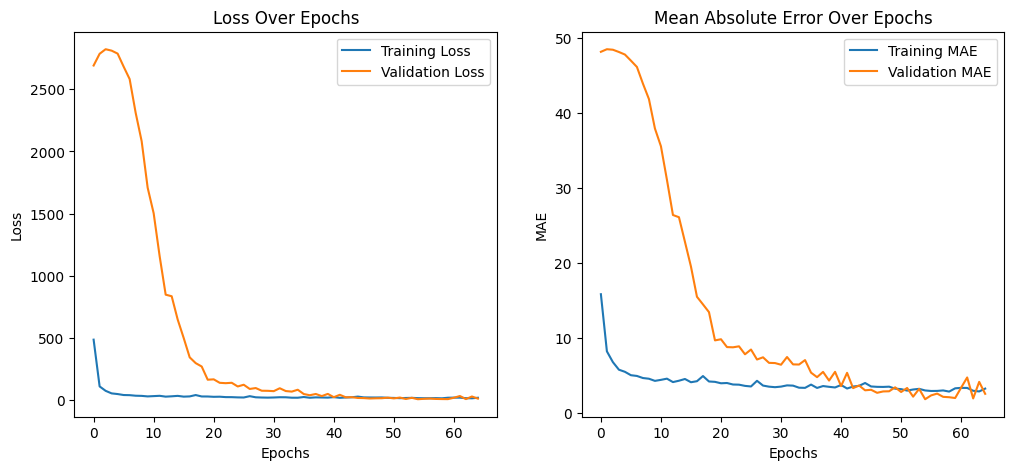

In [16]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation Mean Absolute Error (MAE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

Visually Checking the Predictions (The Most Intuitive Result)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Showing prediction for test image #1771


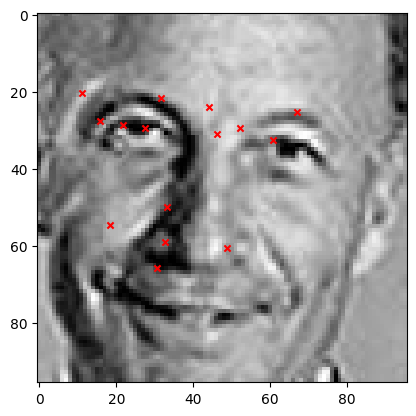

Showing prediction for test image #1708


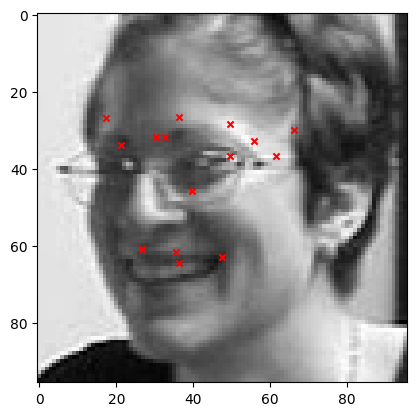

Showing prediction for test image #242


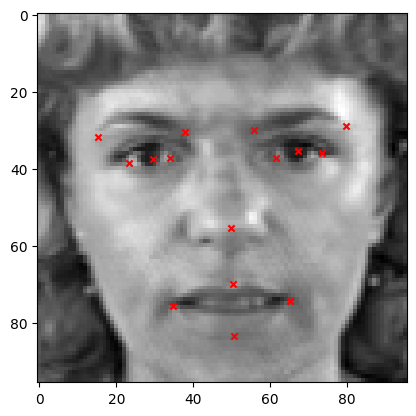

In [17]:
# Preprocess the test data's images just like you did for the training data
X_test = np.array([np.fromstring(image, dtype=int, sep=' ') for image in test_df['Image']]).reshape(-1, 96, 96, 1) / 255.0

# Use the trained model to make predictions on the test images
predictions = model.predict(X_test)

# Clip the predictions to be within the valid range [0, 96]
predictions = np.clip(predictions, 0, 96)

# ===================================================================
# VISUALLY CHECKING THE PREDICTIONS
# ===================================================================

# --- Function to plot keypoints on an image ---
def plot_keypoints(img, points):
    plt.imshow(img.reshape(96, 96), cmap='gray')
    plt.scatter(points[0::2], points[1::2], marker='x', s=20, c='red')
    plt.show()

# --- Display a few random images with their predicted keypoints ---
import random

# Select 3 random image indices from the test set
num_samples_to_show = 3
random_indices = random.sample(range(len(X_test)), num_samples_to_show)

for i in random_indices:
    print(f"Showing prediction for test image #{i}")
    # We are now using the single 'predictions' variable we created above
    plot_keypoints(X_test[i], predictions[i])

The Final Submission File

In [18]:
# --- Step 1: Make predictions on the test set (if you haven't already) ---
# Ensure the test images are loaded and preprocessed
X_test = np.array([np.fromstring(image, dtype=int, sep=' ') for image in test_df['Image']]).reshape(-1, 96, 96, 1) / 255.0

# Get the model's predictions for all test images
predictions = model.predict(X_test)


# --- Step 2: Generate the submission file using the IdLookupTable ---

# Load the lookup table and the sample submission file
lookup_df = pd.read_csv('IdLookupTable.csv')
submission_df = pd.read_csv('SampleSubmission.csv')

# Create a mapping from feature names to the column index
feature_names = list(train_df.drop('Image', axis=1).columns)
feature_indices = {feature: i for i, feature in enumerate(feature_names)}

# Create an empty list to store the final predicted locations
locations = []

# Loop through each row of the lookup table to find the corresponding prediction
for index, row in lookup_df.iterrows():
    image_id = row['ImageId']
    feature_name = row['FeatureName']
    feature_index = feature_indices[feature_name]

    # We are now using the single, already-clipped 'predictions' variable
    predicted_value = predictions[image_id - 1][feature_index]
    locations.append(predicted_value)

# Assign the list of predicted locations to the 'Location' column
submission_df['Location'] = locations

# Save the final DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Successfully created submission.csv!")

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Successfully created submission.csv!
